In [1]:
# STEP 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Time Series Forecasting Libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("All libraries imported successfully!")

All libraries imported successfully!


In [5]:
# STEP 2: Load and Explore the Dataset
# Load the data
df = pd.read_csv(r'D:\Data Science Project\Retail Sales Forecasting\stores_sales_forecasting.csv', encoding='latin1')

# Basic exploration
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df[['Sales', 'Quantity', 'Profit']].describe())

Dataset Shape: (2121, 21)

First 5 rows:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
3       6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
4      11  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   

     Customer Name   Segment        Country             City  ... Postal Code  \
0      Claire Gute  Consumer  United States        Henderson  ...       42420   
1      Claire Gute  Consumer  United States        Henderson  ...       42420   
2   Sean O'Donnell  Consumer  United States  Fort Lauderdale  ...       33311   
3  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   
4  Brosina Hoffman  Consumer  United States      Los Angeles  ...  

In [6]:
# STEP 3: Data Preprocessing and Cleaning
# Convert date columns to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check date range
print(f"\nDate Range: {df['Order Date'].min()} to {df['Order Date'].max()}")

# Sort by date
df = df.sort_values('Order Date')

Missing values:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

Date Range: 2014-01-06 00:00:00 to 2017-12-30 00:00:00


In [7]:
# STEP 4: Create Time Series Data
# Aggregate sales by month (you can change to 'W' for weekly)
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum().reset_index()
monthly_sales.columns = ['ds', 'y']

print("Monthly Sales Data:")
print(monthly_sales.head())
print(f"\nTotal months: {len(monthly_sales)}")

# Also create category-wise data for comparison
monthly_category = df.groupby([pd.Grouper(key='Order Date', freq='M'), 'Category'])['Sales'].sum().unstack().fillna(0)
print("\nCategory-wise Monthly Sales:")
print(monthly_category.head())

Monthly Sales Data:
          ds          y
0 2014-01-31   6242.525
1 2014-02-28   1839.658
2 2014-03-31  14573.956
3 2014-04-30   7944.837
4 2014-05-31   6912.787

Total months: 48

Category-wise Monthly Sales:
Category    Furniture
Order Date           
2014-01-31   6242.525
2014-02-28   1839.658
2014-03-31  14573.956
2014-04-30   7944.837
2014-05-31   6912.787


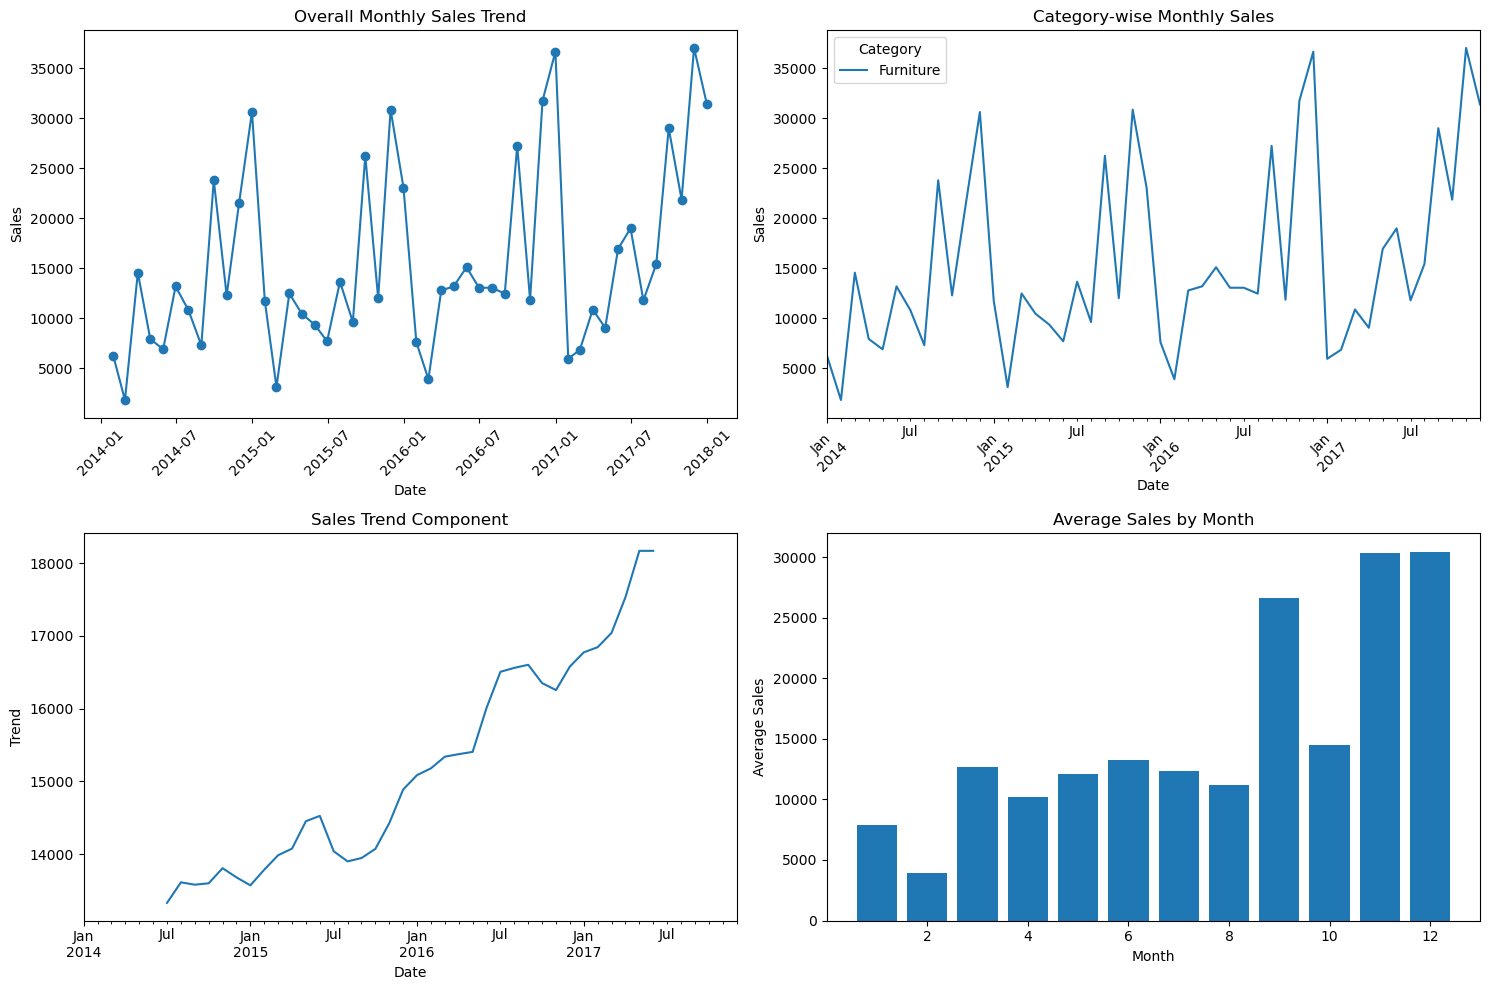

In [8]:
# STEP 5: Exploratory Data Analysis (EDA)
plt.figure(figsize=(15, 10))

# Plot 1: Overall Sales Trend
plt.subplot(2, 2, 1)
plt.plot(monthly_sales['ds'], monthly_sales['y'], marker='o')
plt.title('Overall Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)

# Plot 2: Category-wise Sales
plt.subplot(2, 2, 2)
monthly_category.plot(ax=plt.gca())
plt.title('Category-wise Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Category')
plt.xticks(rotation=45)

# Plot 3: Seasonal decomposition (if enough data)
plt.subplot(2, 2, 3)
if len(monthly_sales) >= 24:  # Need at least 2 years for seasonal decomposition
    decomposition = seasonal_decompose(monthly_sales.set_index('ds')['y'], model='additive', period=12)
    decomposition.trend.plot(ax=plt.gca())
    plt.title('Sales Trend Component')
    plt.xlabel('Date')
    plt.ylabel('Trend')
else:
    plt.text(0.5, 0.5, 'Not enough data for decomposition', ha='center', va='center')
    plt.title('Seasonal Decomposition')

# Plot 4: Monthly distribution
plt.subplot(2, 2, 4)
monthly_sales['month'] = monthly_sales['ds'].dt.month
monthly_avg = monthly_sales.groupby('month')['y'].mean()
plt.bar(monthly_avg.index, monthly_avg.values)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')

plt.tight_layout()
plt.show()

=== TIME SERIES ANALYSIS ===
Stationarity Check for Sales Data:
ADF Statistic: -4.6990
p-value: 0.0001
Critical Values:
	1%: -3.5778
	5%: -2.9253
	10%: -2.6008
Series is stationary


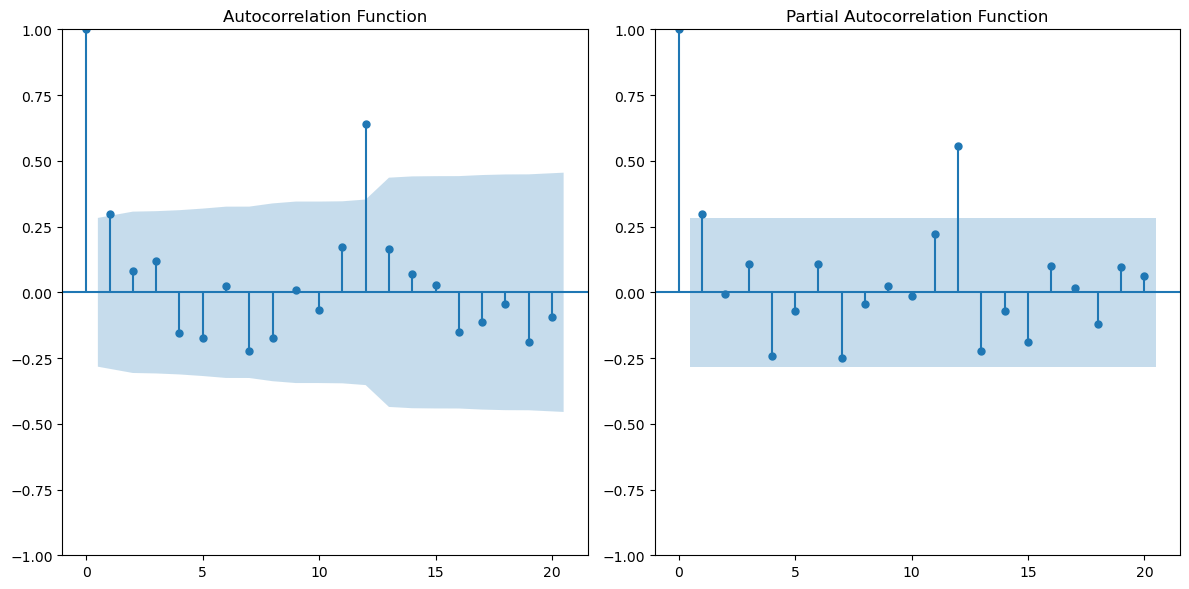

In [9]:
# STEP 6: Time Series Analysis
print("=== TIME SERIES ANALYSIS ===")

# Check stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is non-stationary")

print("Stationarity Check for Sales Data:")
check_stationarity(monthly_sales['y'])

# Plot ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(monthly_sales['y'], ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

plt.subplot(1, 2, 2)
plot_pacf(monthly_sales['y'], ax=plt.gca(), lags=20)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [10]:
# STEP 7: Split Data for Training and Testing
# Use last 6 months for testing (you can adjust this)
split_point = int(len(monthly_sales) * 0.8)  # 80% train, 20% test
train_data = monthly_sales[:split_point]
test_data = monthly_sales[split_point:]

print(f"Training data: {len(train_data)} months")
print(f"Testing data: {len(test_data)} months")
print(f"Training period: {train_data['ds'].min()} to {train_data['ds'].max()}")
print(f"Testing period: {test_data['ds'].min()} to {test_data['ds'].max()}")

Training data: 38 months
Testing data: 10 months
Training period: 2014-01-31 00:00:00 to 2017-02-28 00:00:00
Testing period: 2017-03-31 00:00:00 to 2017-12-31 00:00:00


In [11]:
# STEP 8: ARIMA Model Implementation
print("=== ARIMA MODEL ===")

# Function to evaluate ARIMA model
def evaluate_arima_model(train, test, order):
    history = train['y'].tolist()
    predictions = []
    
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test['y'].iloc[t])
    
    return predictions

# Try different ARIMA orders (you can optimize this)
arima_orders = [(1,1,1), (2,1,2), (1,1,2)]
best_mae = float('inf')
best_order = None
best_predictions = None

for order in arima_orders:
    try:
        predictions = evaluate_arima_model(train_data, test_data, order)
        mae = mean_absolute_error(test_data['y'], predictions)
        
        if mae < best_mae:
            best_mae = mae
            best_order = order
            best_predictions = predictions
            
        print(f"ARIMA{order} - MAE: {mae:.2f}")
    except Exception as e:
        print(f"ARIMA{order} failed: {e}")

print(f"\nBest ARIMA model: {best_order} with MAE: {best_mae:.2f}")

=== ARIMA MODEL ===
ARIMA(1, 1, 1) - MAE: 6565.29


C:\Users\heaz8\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) - MAE: 6735.68
ARIMA(1, 1, 2) - MAE: 6633.41

Best ARIMA model: (1, 1, 1) with MAE: 6565.29


In [13]:
# STEP 9: Facebook Prophet Model
print("\n=== FACEBOOK PROPHET MODEL ===")

# Check what columns we have in train_data
print("Columns in train_data:", train_data.columns.tolist())
print("Shape of train_data:", train_data.shape)

# Prepare data for Prophet - Select only date and sales columns
prophet_train = train_data[['ds', 'y']].copy()  # Explicitly select only these two columns

print("Prophet training data shape:", prophet_train.shape)
print("Prophet training data columns:", prophet_train.columns.tolist())
print("\nFirst few rows of Prophet training data:")
print(prophet_train.head())

# Create and fit Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  # Since we have monthly data
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)

# Fit the model
print("Fitting Prophet model...")
prophet_model.fit(prophet_train)

# Create future dataframe for prediction
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='M')
print(f"Future dataframe created with {len(future)} rows")

# Make predictions
forecast = prophet_model.predict(future)
print("Forecast completed")

# Extract predictions for test period
# Make sure we align dates properly
test_dates = test_data['ds'].values
prophet_predictions = forecast[forecast['ds'].isin(test_dates)]['yhat'].values

print(f"Test dates: {len(test_dates)}, Predictions: {len(prophet_predictions)}")

# Calculate metrics
prophet_mae = mean_absolute_error(test_data['y'], prophet_predictions)
prophet_rmse = np.sqrt(mean_squared_error(test_data['y'], prophet_predictions))

print(f"Prophet Model - MAE: {prophet_mae:.2f}")
print(f"Prophet Model - RMSE: {prophet_rmse:.2f}")


=== FACEBOOK PROPHET MODEL ===
Columns in train_data: ['ds', 'y', 'month']
Shape of train_data: (38, 3)
Prophet training data shape: (38, 2)
Prophet training data columns: ['ds', 'y']

First few rows of Prophet training data:
          ds          y
0 2014-01-31   6242.525
1 2014-02-28   1839.658
2 2014-03-31  14573.956
3 2014-04-30   7944.837
4 2014-05-31   6912.787


18:41:57 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet model...


18:41:58 - cmdstanpy - INFO - Chain [1] done processing


Future dataframe created with 48 rows
Forecast completed
Test dates: 10, Predictions: 10
Prophet Model - MAE: 4026.71
Prophet Model - RMSE: 4428.18


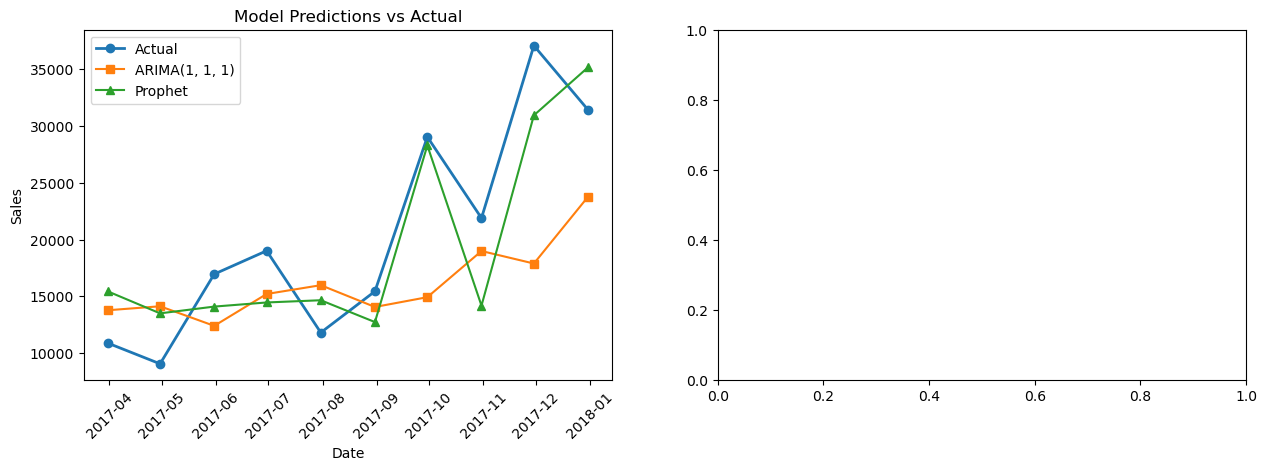

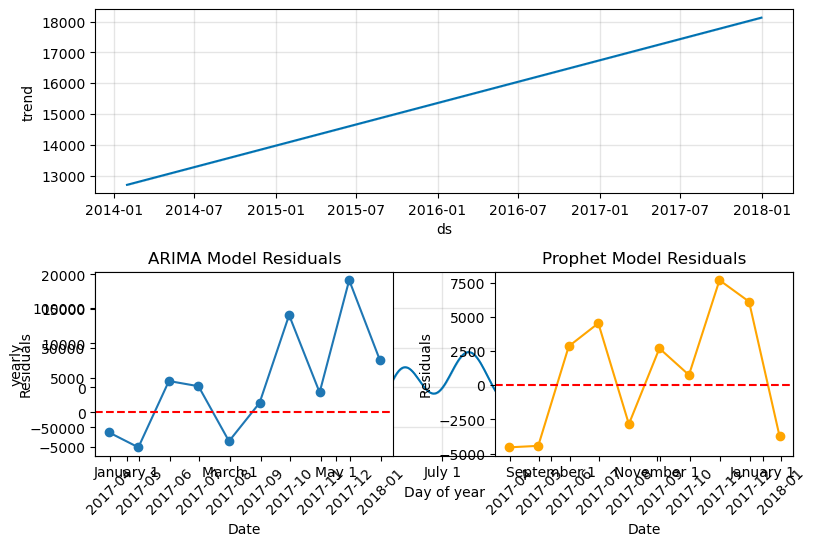

In [14]:
# STEP 10: Model Comparison and Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Actual vs Predicted
plt.subplot(2, 2, 1)
plt.plot(test_data['ds'], test_data['y'], label='Actual', marker='o', linewidth=2)
plt.plot(test_data['ds'], best_predictions, label=f'ARIMA{best_order}', marker='s')
plt.plot(test_data['ds'], prophet_predictions, label='Prophet', marker='^')
plt.title('Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)

# Plot 2: Prophet forecast components
plt.subplot(2, 2, 2)
prophet_model.plot_components(forecast)
plt.tight_layout()

# Plot 3: Residuals for ARIMA
plt.subplot(2, 2, 3)
arima_residuals = test_data['y'].values - best_predictions
plt.plot(test_data['ds'], arima_residuals, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('ARIMA Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.xticks(rotation=45)

# Plot 4: Residuals for Prophet
plt.subplot(2, 2, 4)
prophet_residuals = test_data['y'].values - prophet_predictions
plt.plot(test_data['ds'], prophet_residuals, marker='o', color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Prophet Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

=== FUTURE FORECASTING ===


18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing


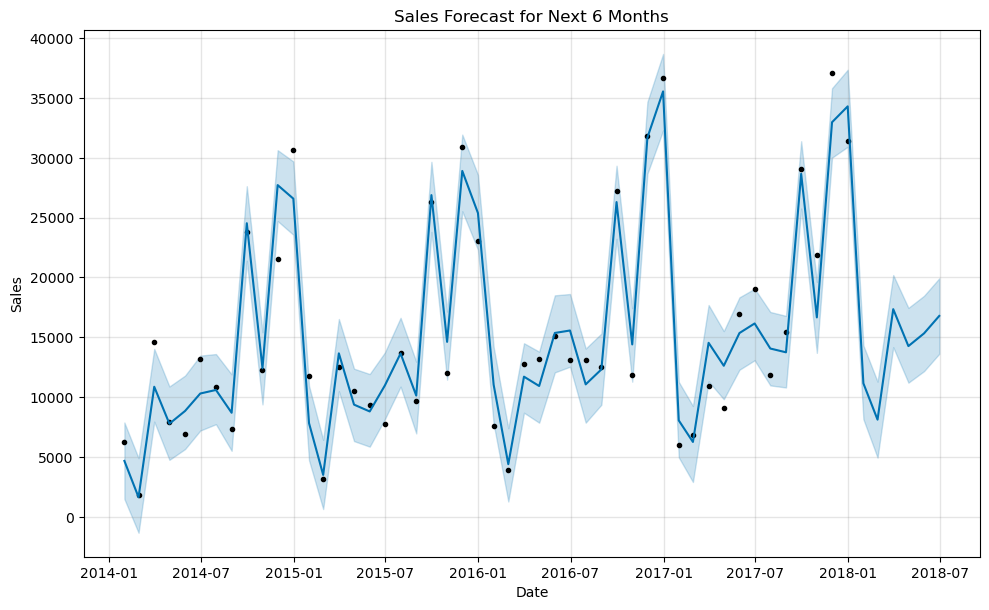


Future Sales Predictions:
           ds      yhat  yhat_lower  yhat_upper
48 2018-01-31  11152.36     8154.54    14315.19
49 2018-02-28   8115.76     4944.93    11291.29
50 2018-03-31  17351.40    14169.84    20202.53
51 2018-04-30  14262.61    11207.05    17455.50
52 2018-05-31  15329.27    12171.49    18470.82
53 2018-06-30  16785.92    13619.08    19927.78


In [15]:
# STEP 11: Future Forecasting
print("=== FUTURE FORECASTING ===")

# Use the best model (Prophet usually performs better with limited data) to forecast next 6 months
final_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)

final_model.fit(monthly_sales[['ds', 'y']])

# Create future dataframe for next 6 months
future_forecast = final_model.make_future_dataframe(periods=6, freq='M')
future_predictions = final_model.predict(future_forecast)

# Plot the final forecast
fig = final_model.plot(future_predictions)
plt.title('Sales Forecast for Next 6 Months')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Show future predictions
future_dates = future_predictions[future_predictions['ds'] > monthly_sales['ds'].max()][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print("\nFuture Sales Predictions:")
print(future_dates.round(2))

In [16]:
# STEP 12: Model Evaluation Summary
print("=== MODEL PERFORMANCE SUMMARY ===")
print(f"ARIMA{best_order}:")
print(f"  - MAE: {best_mae:.2f}")
print(f"  - RMSE: {np.sqrt(mean_squared_error(test_data['y'], best_predictions)):.2f}")

print(f"\nProphet:")
print(f"  - MAE: {prophet_mae:.2f}")
print(f"  - RMSE: {prophet_rmse:.2f}")

# Calculate percentage errors
mean_actual = test_data['y'].mean()
print(f"\nMean Absolute Percentage Error:")
print(f"  - ARIMA: {(best_mae/mean_actual)*100:.2f}%")
print(f"  - Prophet: {(prophet_mae/mean_actual)*100:.2f}%")

# Determine best model
if prophet_mae < best_mae:
    best_model_name = "Prophet"
    best_metric = prophet_mae
else:
    best_model_name = f"ARIMA{best_order}"
    best_metric = best_mae

print(f"\n🎯 Best Performing Model: {best_model_name} with MAE: {best_metric:.2f}")

=== MODEL PERFORMANCE SUMMARY ===
ARIMA(1, 1, 1):
  - MAE: 6565.29
  - RMSE: 8493.99

Prophet:
  - MAE: 4026.71
  - RMSE: 4428.18

Mean Absolute Percentage Error:
  - ARIMA: 32.41%
  - Prophet: 19.88%

🎯 Best Performing Model: Prophet with MAE: 4026.71


In [17]:
# STEP 13: Business Insights and Recommendations
print("=== BUSINESS INSIGHTS ===")

# Calculate key metrics
total_sales = monthly_sales['y'].sum()
avg_monthly_srowth = monthly_sales['y'].pct_change().mean() * 100
best_month = monthly_sales.loc[monthly_sales['y'].idxmax()]

print(f"1. Total Sales (2014-2017): ${total_sales:,.2f}")
print(f"2. Average Monthly Growth Rate: {avg_monthly_srowth:.2f}%")
print(f"3. Best Sales Month: {best_month['ds'].strftime('%B %Y')} - ${best_month['y']:,.2f}")
print(f"4. Forecasted Next 6 Months Sales: ${future_dates['yhat'].sum():,.2f}")

print("\n📈 Recommendations:")
print("• Monitor seasonal patterns for inventory planning")
print("• Consider promotional activities during low-sales months")
print("• Use the forecast for budget allocation and resource planning")
print("• Continue collecting data to improve model accuracy")

=== BUSINESS INSIGHTS ===
1. Total Sales (2014-2017): $741,999.80
2. Average Monthly Growth Rate: 39.43%
3. Best Sales Month: November 2017 - $37,056.72
4. Forecasted Next 6 Months Sales: $82,997.32

📈 Recommendations:
• Monitor seasonal patterns for inventory planning
• Consider promotional activities during low-sales months
• Use the forecast for budget allocation and resource planning
• Continue collecting data to improve model accuracy
